In [7]:
# Subject 4: latency and capacity estimation for a network connection from asymmetric measurements
# What we are interested in here is the mean time required for sending a message of a given length.

In [ ]:
# Our tasks
# 1) Start by working on the first dataset (liglab2). Plot the time evolution of transmission time, if useful at different moments in time and/or on different time scales, in order to evaluate the temporal stability of the phenomenon. Can the variations be explained solely by message size?
# 2) Plot the transmission time as a function of message size. You should observe a "disruption", a size starting from which the variability changes qualitatively. Estimate this time graphically, in order to treat the two classes of message size separately.
# 3) Perform a linear regression for each class and estimate the corresponding values of L and C. Superpose the result of this regression onto the preceding plot.

In [9]:
# Let start trying to read the input file "liglab2.log" and take the values we need.
# [1421761682.052172] 665 bytes from lig-publig.imag.fr (129.88.11.7): icmp_seq=1 ttl=60 time=22.5 ms

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
file = open('liglab2.log','r')
#for lines in file:
    #print(lines)

In [ ]:
# Verifying if we have invalid lines, eg. messages that was not received.

In [3]:
file = open('liglab2.log','r')
invalidLines = 0
validLines = 0
for lines in file:
    values = lines.split()
    if(len(values) < 10): #10 is the size of a full row
        invalidLines += 1
    else:
        validLines += 1 
print("Total valid lines: " + str(validLines))
print("Total invalid lines: " + str(invalidLines))

Total valid lines: 44036
Total invalid lines: 377


In [2]:
# Start by working on the first dataset (liglab2). Plot the time evolution of transmission time, 
# if useful at different moments in time and/or on different time scales, in order to evaluate 
# the temporal stability of the phenomenon. Can the variations be explained solely by message size?

#[1421761682.052172] 665 bytes from lig-publig.imag.fr (129.88.11.7): icmp_seq=1 ttl=60 time=22.5 ms

44036


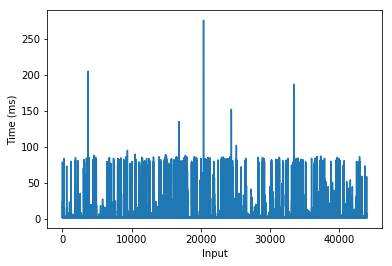

In [33]:
file = open('liglab2.log','r')
times = []
sizes = []
for lines in file:
    values = lines.split()
    if(len(values) == 10):
        times.append(float(values[8].split('=')[1]))
        sizes.append(float(values[1]))
print(len(times))
plt.ylabel('Time (ms)')
plt.xlabel('Input')
plt.plot(times)


44036
[665.0, 1373.0, 262.0, 1107.0, 1128.0, 489.0, 1759.0, 1146.0, 884.0, 1422.0]


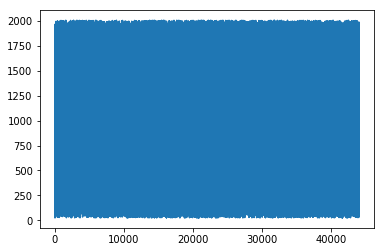

In [39]:
print(len(sizes))
print(sizes[:10])
plt.plot(sizes)

{}


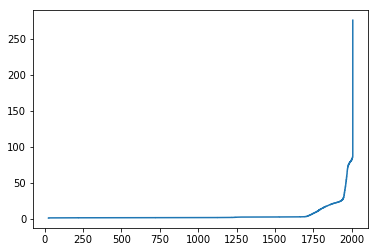

In [57]:
# We need to do something like this, sort both lists, but without lost the relation. 
plt.plot(sorted(sizes),sorted(times)) #Example of print in order, but the relations for each pair are wrong